# Pima Indians Diabetes Data Set用RBF核的SVM进行糖尿病预测

In [1]:
# 首先 import 必要模块
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

## 读取数据

In [2]:
# 读取数据
dpath = './'

# 直接采用原始特征
train = pd.read_csv(dpath + "FE_pima-indians-diabetes.csv")

# 看一下头五行数据
train.head()

,pregnants,Plasma_glucose_concentration,blood_pressure,Triceps_skin_fold_thickness,serum_insulin,BMI,Diabetes_pedigree_function,Age,Target
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549,0
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnants                       768 non-null float64
Plasma_glucose_concentration    768 non-null float64
blood_pressure                  768 non-null float64
Triceps_skin_fold_thickness     768 non-null float64
serum_insulin                   768 non-null float64
BMI                             768 non-null float64
Diabetes_pedigree_function      768 non-null float64
Age                             768 non-null float64
Target                          768 non-null int64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


## 准备数据

In [4]:
# drop target and get labels
y_train = train['Target']
X_train = train.drop(['Target'], axis = 1)

# 保存特征名字备用（可视化）
feat_name = X_train.columns

## 模型训练
使用GridSearchCV进行交叉验证进行参数调优

RBF核的SVM需要对核函数的两个超参数进行调优：gamma、C。

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#需要调优的参数
#tuned_parameters = {'gamma': [0.0005, 0.0006, 0.0007, 0.0013],
#                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
# 因为有768各样本，所以gamma默认值为0.0013，我们希望它更小
gammas = [0.0005, 0.0006, 0.0007, 0.0013]
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(gamma = gammas, C= Cs)

SVC = SVC(kernel='rbf')
grid = GridSearchCV(SVC, tuned_parameters, cv = 5, scoring = 'accuracy', n_jobs = 5, verbose = 5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 140 out of 140 | elapsed:    3.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'gamma': [0.0005, 0.0006, 0.0007, 0.0013], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

### 通过五折交叉验证对超参数进行调优后得到最优超参数

In [6]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.76953125
{'C': 100, 'gamma': 0.0006}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


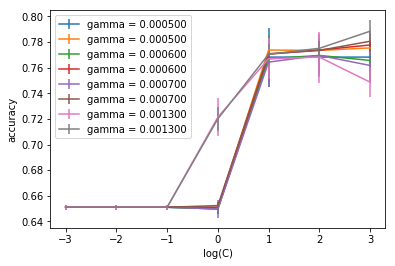

In [7]:
# plot CV误差曲线
test_means = grid.cv_results_['mean_test_score']
test_stds = grid.cv_results_['std_test_score']
train_means = grid.cv_results_['mean_train_score']
train_stds = grid.cv_results_['std_train_score']

# 把一维数组变成二维数组
n_Cs = len(Cs)
number_gammas = len(gammas)
test_scores = np.array(test_means).reshape(n_Cs, number_gammas)
train_scores = np.array(train_means).reshape(n_Cs, number_gammas)
test_stds = np.array(test_stds).reshape(n_Cs, number_gammas)
train_stds = np.array(train_stds).reshape(n_Cs, number_gammas)

x_axis = np.log10(Cs)
for i, value in enumerate(gammas):
    plt.errorbar(x_axis, test_scores[:, i], yerr = test_stds[:, i], label = 'gamma = %f' % gammas[i])
    plt.errorbar(x_axis, train_scores[:, i], yerr = train_stds[:, i], label = 'gamma = %f' % gammas[i])

plt.legend()
plt.xlabel('log(C)')
plt.ylabel('accuracy')

plt.show()